In [64]:
import sys
import os
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import torch
import torch.nn.functional as F
from Models.PtychoFormer import PtychoFormer
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms.functional import resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
# Define the path to the directory containing the PNG images
data_path = "/home/xguo50/PtychoFormer/5by5realdata/ptfiles3/data_12.pt"
# data_path = "/home/xguo50/PtychoFormer/datasetrealryuma/36/data_0.pt"

In [66]:
data = torch.load(data_path)
print("Data loaded successfully!")
      
print(data.keys())
print(data['input'].shape)
print(data['label'].shape)

Data loaded successfully!
dict_keys(['input', 'label'])
torch.Size([25, 2048, 2048])
torch.Size([2, 300, 300])


torch.Size([25, 2048, 2048])


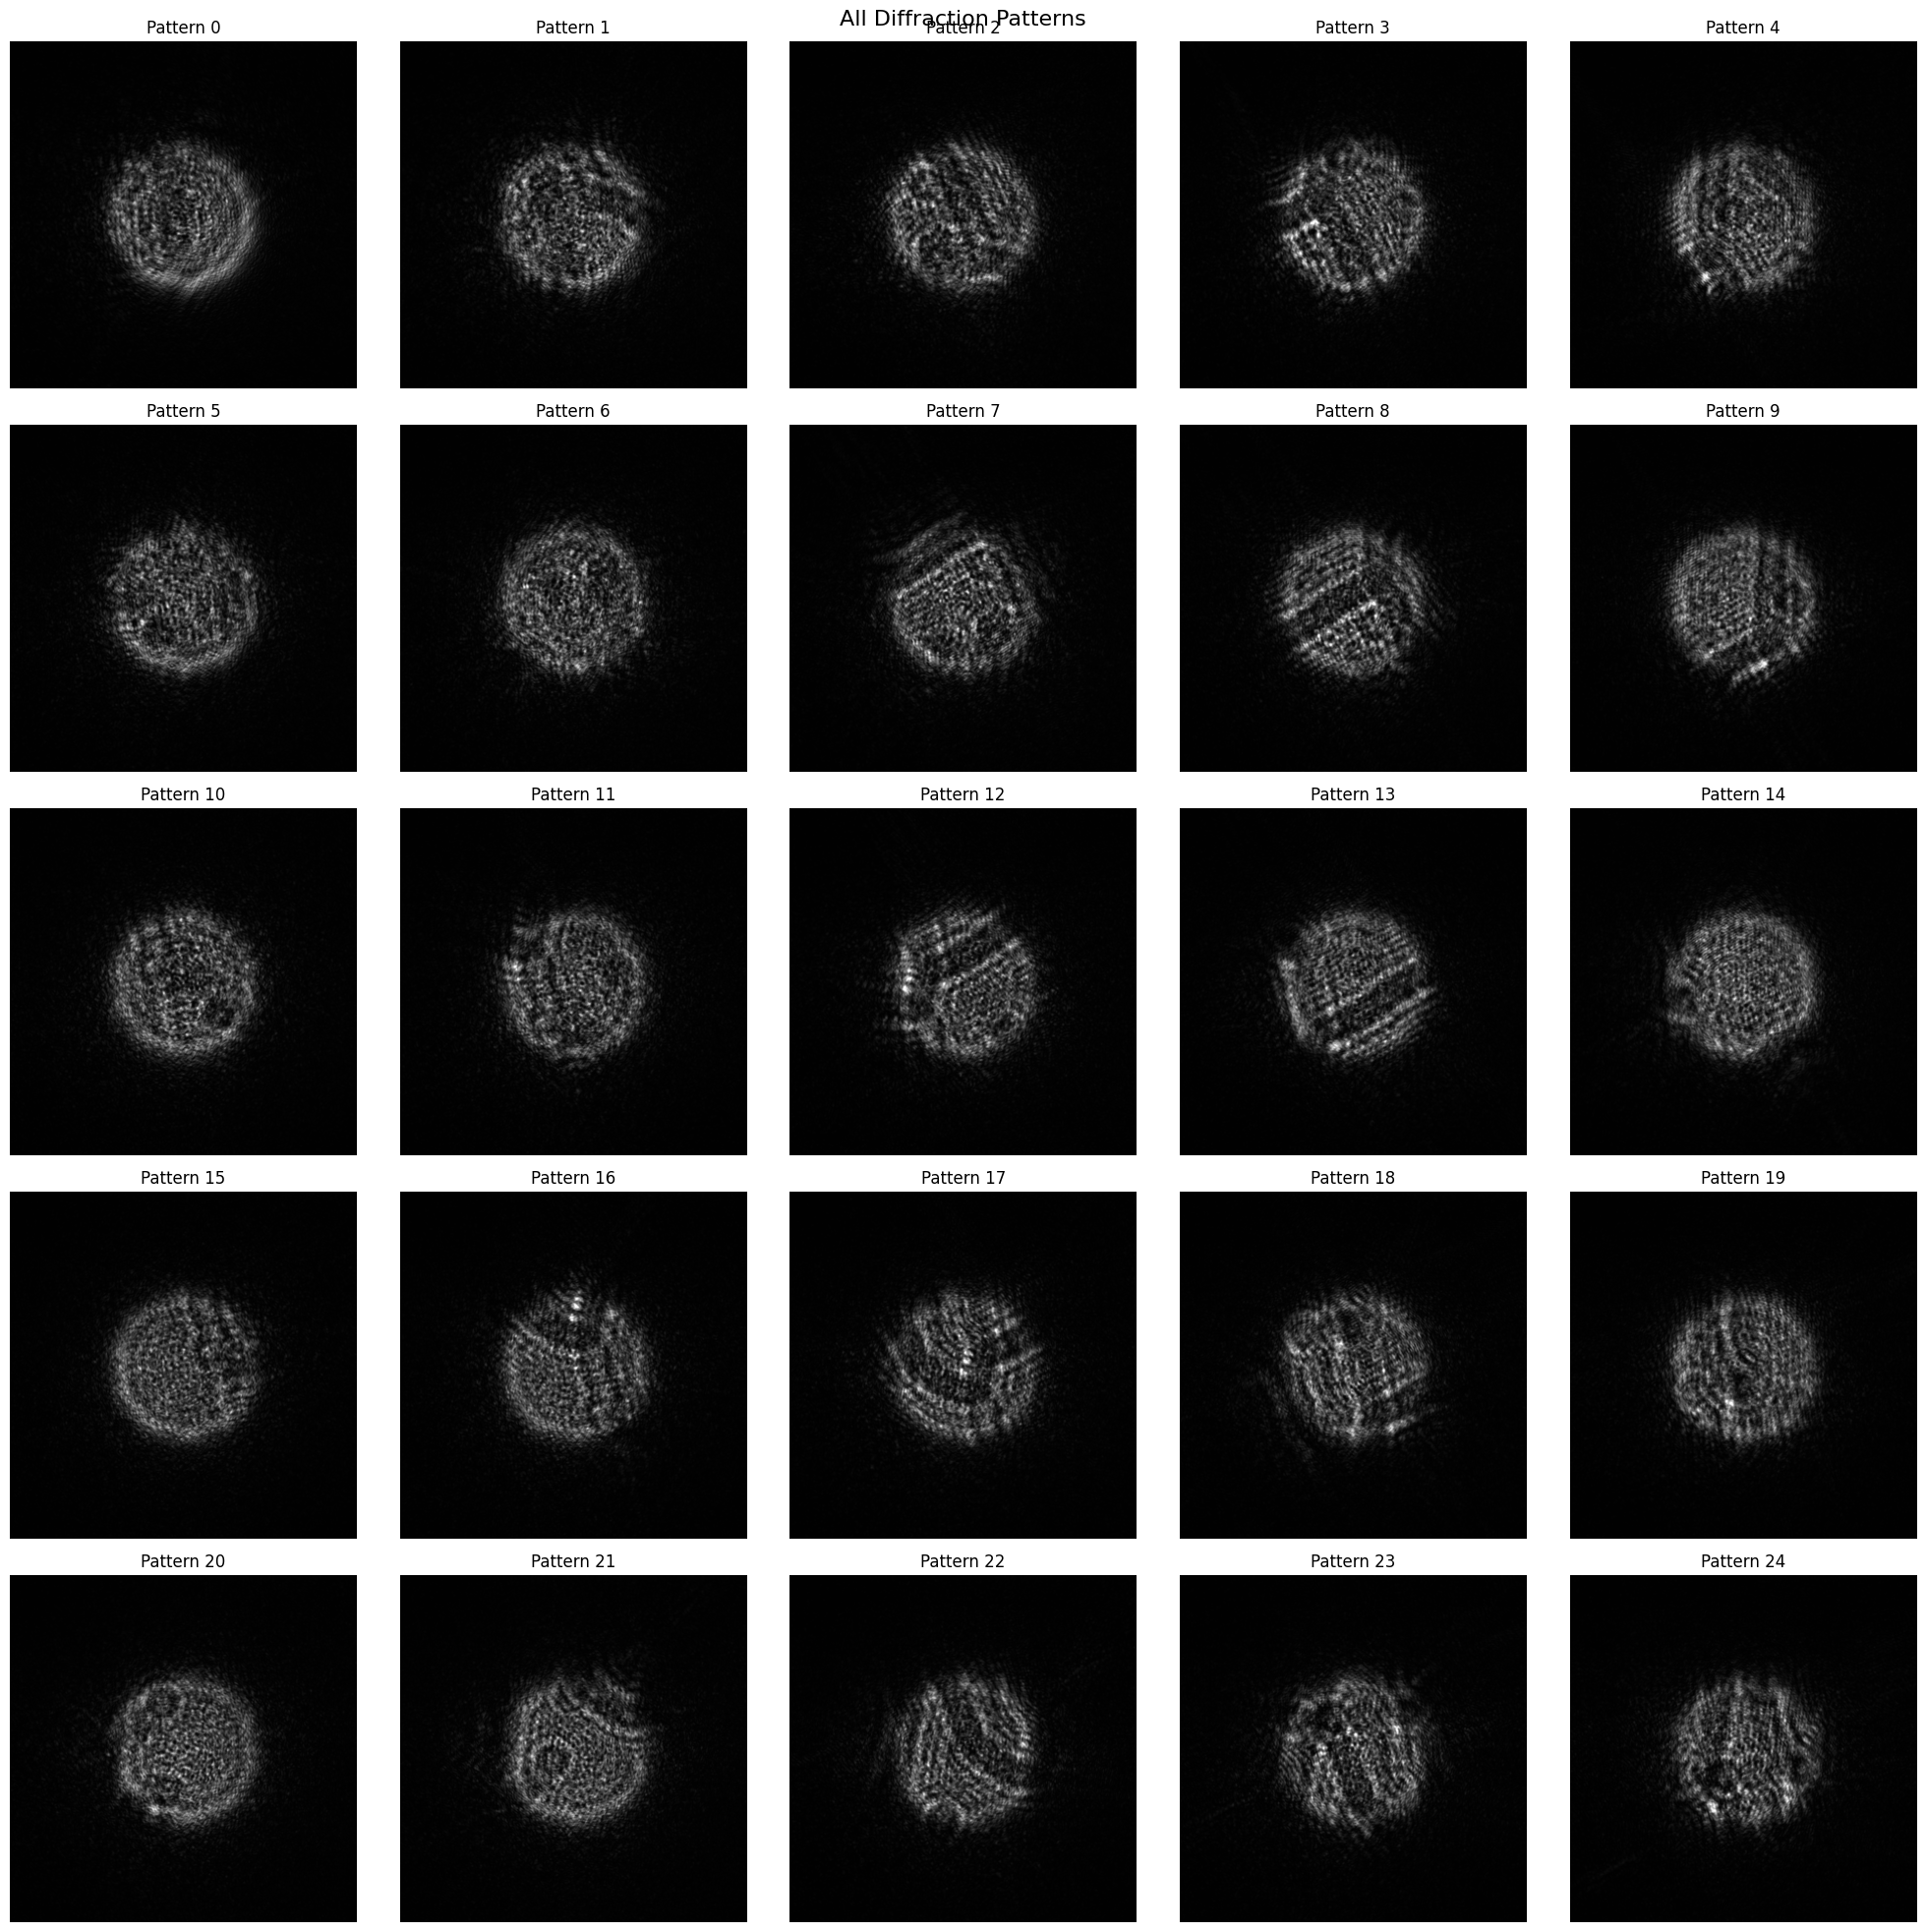

In [67]:
patterns = data['input']
patterns = patterns.to(device)
print(patterns.shape)

fig, axs = plt.subplots(5, 5, figsize=(20, 20)) 
fig.suptitle("All Diffraction Patterns", fontsize=16)
for i in range(25):  
    row = i // 5  
    col = i % 5  

    pattern = patterns[i].cpu().numpy()
    
    axs[row, col].imshow(pattern, cmap='gray')
    axs[row, col].set_title(f"Pattern {i}")
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()

In [68]:
model = PtychoFormer().to(device)
checkpoint_path = '/home/xguo50/PtychoFormer/attempt5by5.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model"])
model.eval() 

PtychoFormer(
  (encoder): PtychoFormerEncoder(
    (stages): ModuleList(
      (0): PtychoFormerEncoderStage(
        (overlap_patch_merge): OverlapPatchMerging(
          (0): Conv2d(25, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
          (1): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
        )
        (blocks): Sequential(
          (0): PtychoFormerEncoderBlock(
            (0): ResidualAdd(
              (fn): Sequential(
                (0): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
                (1): EfficientMultiHeadAttention(
                  (reducer): Sequential(
                    (0): Conv2d(64, 64, kernel_size=(8, 8), stride=(8, 8))
                    (1): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
                  )
                  (att): MultiheadAttention(
                    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
                  )
                

In [69]:
import torch.nn.functional as F

with torch.no_grad():
    with torch.cuda.amp.autocast():
        result_tensor = data['input'].to(device).float()
        result_tensor = result_tensor.unsqueeze(0)
        print(result_tensor.shape)
        result_tensor = F.interpolate(result_tensor, size=(400, 400), mode='bilinear', align_corners=False)
        prediction = model(result_tensor)
print(prediction.shape)

torch.Size([1, 25, 2048, 2048])
torch.Size([1, 2, 400, 400])


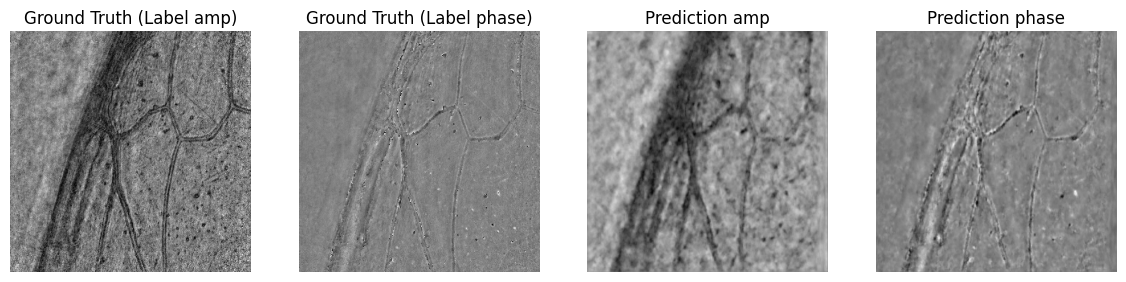

In [70]:
pred_amp = prediction[0, 0].cpu().detach().numpy()
pred_phase = prediction[0,1].cpu().detach().numpy()

plt.figure(figsize=(18, 6))
# plt.subplot(1, 5, 1)
# plt.imshow(input_img, cmap='gray')
# plt.title(f"Diffraction Pattern (Input)")
# plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(data['label'][0], cmap='gray')
plt.title("Ground Truth (Label amp)")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(data['label'][1], cmap='gray')
plt.title("Ground Truth (Label phase)")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(pred_amp, cmap='gray')
plt.title("Prediction amp")
plt.axis("off")


plt.subplot(1, 5, 5)
plt.imshow(pred_phase, cmap='gray')
plt.title("Prediction phase")
plt.axis("off")
plt.show()